In [1]:
import tensorflow as tf

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [2]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [3]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')

# https://commons.wikimedia.org/wiki/File:Vassily_Kandinsky,_1913_-_Composition_7.jpg
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

In [4]:
# image를 load하기 위한 함수
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [5]:
# show image function
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    
    plt.imshow(image)
    if title:
        plt.title(title)

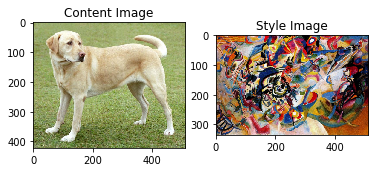

In [6]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1,2,1)
imshow(content_image, title='Content Image')

plt.subplot(1,2,2)
imshow(style_image, title='Style Image')

# TF-Hub를 이용한 Fast Style Transfer

In [7]:
!pip install tensorflow_hub
import tensorflow_hub as hub
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')

In [8]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4589480990361134059
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4930941747
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4968283311023133242
physical_device_desc: "device: 0, name: GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


Total time: 1.2


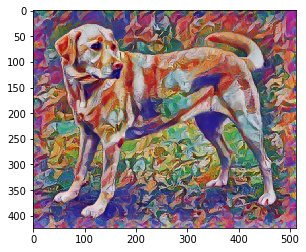

In [9]:
import time
start = time.time()
with tf.device('/CPU:0'):
    start = time.time()
    stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
    transform_image = tensor_to_image(stylized_image)
plt.imshow(transform_image)
end = time.time()
print("Total time: {:.1f}".format(end-start))

Total time: 2.6


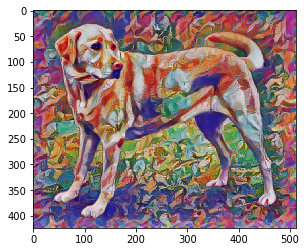

In [10]:
import time
start = time.time()
stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
transform_image = tensor_to_image(stylized_image)
plt.imshow(transform_image)
end = time.time()
print("Total time: {:.1f}".format(end-start))

## Content와 Style 표현 정의
이미지의 콘텐츠와 스타일 표현을 얻기 위해, model 내 중간 레이어(layer)를 살펴보겠습니다. 중간 레이어들은 피쳐맵(feature map)을 나타나는데 이는 깊어질수록 높이가 커지게 됩니다. 이번 경우, 미리 학습된 이미지 분류 신경망인 VGG19 신경망을 사용합니다. 이 신경망의 중간 레이어들은 이미지의 스타일과 콘텐츠 표현을 정의하는 데 필요합니다. 중간 레이어들에서 입력 이미지의 해당 스타일 및 콘텐츠가 목적 표현에도 맞춰지도록 시도합니다.

In [11]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))  # content image(리트리버)
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [12]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('Labrador_retriever', 0.49317113),
 ('golden_retriever', 0.23665294),
 ('kuvasz', 0.03635755),
 ('Chesapeake_Bay_retriever', 0.024182769),
 ('Greater_Swiss_Mountain_dog', 0.018646104)]

In [13]:
# style representation과 content representation 추출을 위해 pretrained된 vgg19를 사용
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
    print(layer.name)


input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [14]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer of interest
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## 왜 레이어의 중간 부분을 사용하는가?
학습된 이미지 분류 신경망의 중간 레이어 출력값들이 스타일과 콘텐츠 표현을 어떻게 정의하는지 궁금할 겁니다.  
높은 단계에서, 이 현상은 신경망이 (신경망이 학습해 온)이미지 분류를 하기 위해서는 반드시 이미지를 이해해야 하는 사실로 설명될 수 있습니다. 이는 원본 이미지를 입력 픽셀(pixel)로 사용하고 원본 이미지 픽셀을 이미지 내 피쳐들의 복잡한 이해형태로 변형하는 방식으로 내부 표현을 설계합니다. 이는 CNN(Convolution Neural Network)이 얼마나 잘 일반화될 수 있는지에 대한 이유이기도 합니다. CNN은 배경이나 다른 노이즈들에 영향을 받지 않는 클래스 내에 존재하는 불변성(invariances)을 포착하고 피쳐들을 정의할 수 있습니다.  
그러므로 원본 이미지가 입력되고 분류 레이블(label)이 출력되는 구간 어딘가에서 model은 복잡한 피쳐 추출기로서 작동합니다. 따라서 중간 레이어에 접근함으로써 입력 이미지의 콘텐츠와 스타일을 설명할 수 있습니다.

![feature](./feature.png)  
**Content Representation** : Content image를 Conv연산을 하여 얻은 feature map 
**Content Reconstruction** : Content Representation으로 Content loss를 최적화하여 만들어진 이미지  
**Style Representation** : Style image의 feature map  
**Style Reconstruction** : Style Representation을 최적화하여 만들어진 이미지   

### Content feature
레이어가 깊어지면 픽셀 수준의 정보는 사라지게 되지만 입력 이미지가 가진 semantic 정보(위 그림에서 강 옆의 집들)은 그대로 유지된다. 반면에 낮은 레이어는 입력 이미지와 거의 동일하다. 따라서 깊은 레이어에서 content feature를 추출한다.  

### Style feature
style 특성은 Gram matrix를 기반으로 한다. style/texture 특성은 공간적인 정보와 무관해야 하므로 각 레이어의 feature map 사이의 상관관계(correlation)를 나타낼 수 있는 Gram matrix를 사용하게 된다.  
[참고](https://www.popit.kr/neural-style-transfer-%EB%94%B0%EB%9D%BC%ED%95%98%EA%B8%B0/)

# Model 생성
* 각 Content feature와 style feature를 얻기 위한 모델 생성(VGG19사용)

In [15]:
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    
    outputs = [vgg.get_layer(name).output for name in layer_names]
    
    model = tf.keras.Model(inputs=[vgg.input], outputs=outputs)
    return model

In [16]:
# Style Feature를 얻는 모델 생성
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

# Style feature의 개략적인 확인
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()

block1_conv1
  shape:  (1, 336, 512, 64)
  min:  0.0
  max:  835.5256
  mean:  33.97525

block2_conv1
  shape:  (1, 168, 256, 128)
  min:  0.0
  max:  4625.8857
  mean:  199.82687

block3_conv1
  shape:  (1, 84, 128, 256)
  min:  0.0
  max:  8789.239
  mean:  230.78099

block4_conv1
  shape:  (1, 42, 64, 512)
  min:  0.0
  max:  21566.135
  mean:  791.24005

block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  3189.2542
  mean:  59.179478



### Style 계산
* 행렬의 Gram Matrix를 구하고 행렬간 차이가 최소가 되도록 loss function을 계산한다.
![gram1](gram1.png)
![gram2](gram2.png)

In [17]:
def gram_matrix(input_tensor):
    # out[b,c,d] = sum ij input_tensor[b,i,j,c] * input_tensor[b,i,j,d]
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

# Style, Content Model

In [18]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers # 5
        self.content_layers = content_layers # 1
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False
        
    def call(self, inputs):
        # inputs => [0, 1]
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = outputs[:self.num_style_layers], outputs[self.num_style_layers:]
        
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
        
        content_dict = {content_name:value for content_name, value in zip(self.content_layers, content_outputs)}
        style_dict = {style_name:value for style_name, value in zip(self.style_layers, style_outputs)}
        
        return {'content': content_dict, 'style':style_dict}

In [19]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

style_results = results['style']

print('Styles:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

print("Contents:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0055228453
    max:  28014.521
    mean:  263.7902

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  61479.484
    mean:  9100.949

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  545623.44
    mean:  7660.976

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  4320501.0
    mean:  134288.84

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  110005.34
    mean:  1487.0381

Contents:
   block5_conv2
    shape:  (1, 26, 32, 512)
    min:  0.0
    max:  2410.8796
    mean:  13.764149


### 학습

In [20]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

optimize를 위해 `tf.Variable`를 사용

In [21]:
image = tf.Variable(content_image)

In [22]:
# image는 [0, 1]의 float image로 되어있으므로 clip하여 사용
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [23]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

Total Loss의 가중치 파라미터를 지정한다

In [24]:
style_weight = 1e-2
content_weight=1e4

In [25]:
# 논문 스타일과 다르게 코딩되어 있는 듯 하다.
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    
    # style loss
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers
    
    # content loss
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    return style_loss + content_loss

In [26]:
def train_step(image): # content image를 입력으로
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
    
    grad = tape.gradient(loss, image) # loss를 기반으로 image를 학습시킴
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

# 정리
1. image = tf.Variable(content_image) => content_image를 Variable로 하여 image 자체를 변경시킴  
2. VGG19에서 style_target, content_target feature를 미리 구함(이 값은 불변값)  
3. content_image를 입력으로 style_outputs, content_outputs를 구하고 각각 style_target, content_target loss function으로 loss를 최소화하도록 학습

학습

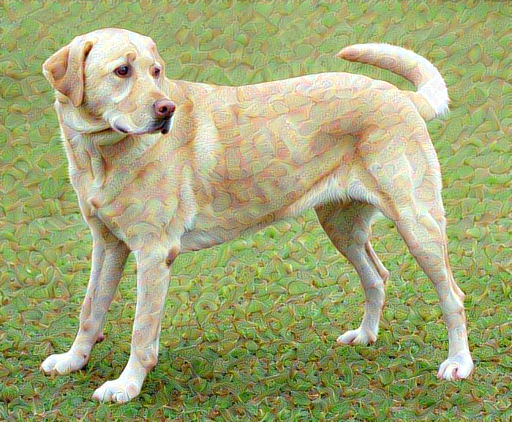

In [27]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

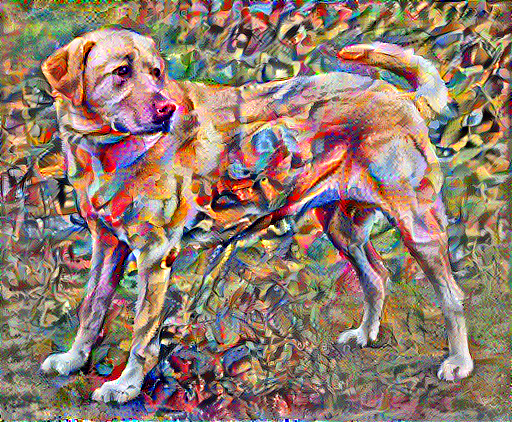

Train step: 1000
Total time: 234.7


In [28]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(",", end='.')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))
end = time.time()
print("Total time: {:.1f}".format(end-start))

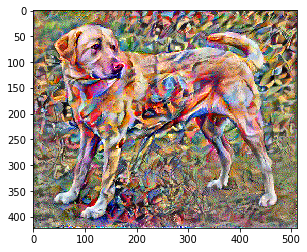

In [29]:
plt.imshow(image.numpy()[0,:,:,:])
plt.imsave('result.jpg',image.numpy()[0,:,:,:])

# Total variation loss
Style Transfer의 단점 중 하나는 고주파 대역을 생성한다는 것입니다. 

In [30]:
def high_pass_x_y(image):
    x_var = image[:,:,1:,:] - image[:,:,:-1,:]
    y_var = image[:,1:,:,:] - image[:,:-1,:,:]

    return x_var, y_var

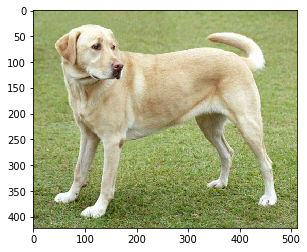

In [31]:
plt.imshow(content_image[0,:,:,:])

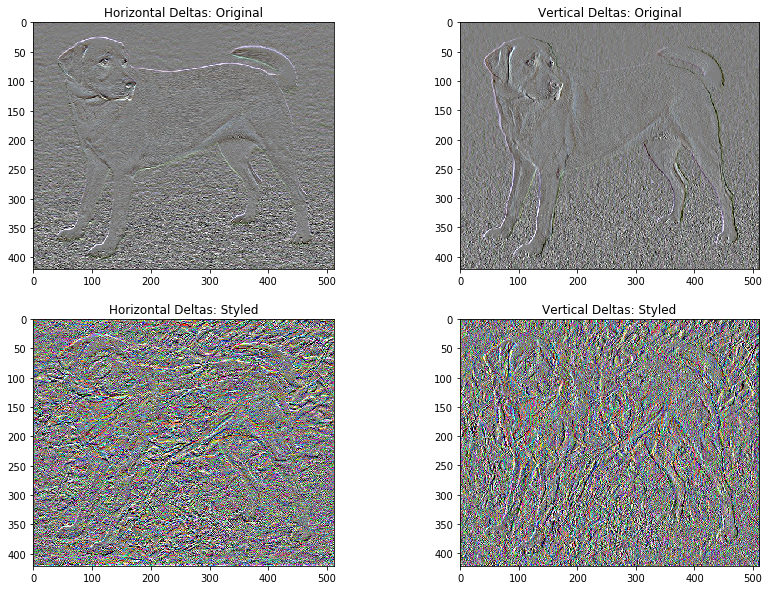

In [32]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2,2,4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

이 결과는 고주파 component가 얼마나 증가했는지를 보여준다. 이 결과는 Sobel Edge Detector을 사용해도 비슷한 결과를 보여준다.

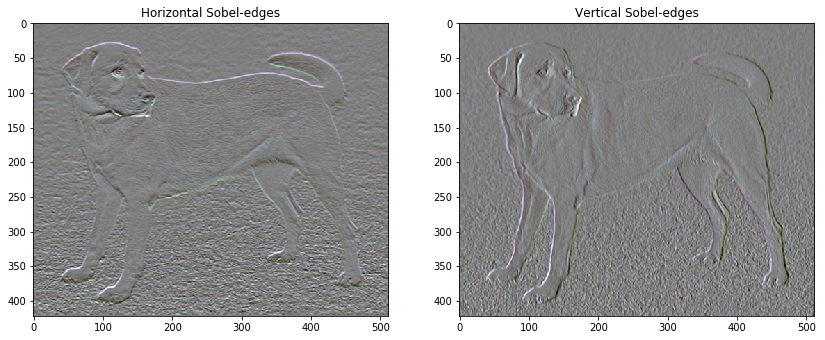

In [33]:
plt.figure(figsize=(14,10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1,2,1)
imshow(clip_0_1(sobel[...,0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1,2,2)
imshow(clip_0_1(sobel[...,1]/4+0.5), "Vertical Sobel-edges")

In [34]:
# 수치화된 Total_variation_loss를 구하는 함수
def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [35]:
total_variation_loss(image).numpy()

149247.05

In [36]:
# Tensorflow에서는 total_variation loss 함수를 제공한다
tf.image.total_variation(image).numpy()

array([149247.05], dtype=float32)

# Re-run the optimization
total_variation_weight를 loss function에 추가하여 학습하면서 성능 변화를 확인한다.

In [37]:
total_variation_weight=30

In [38]:
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight*tf.image.total_variation(image)
        
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

In [39]:
image = tf.Variable(content_image)

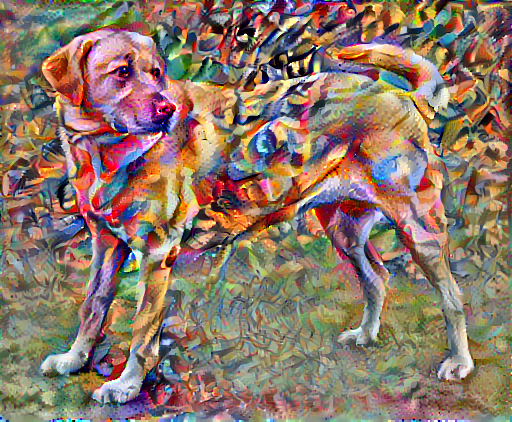

Train step: 1000
Total time: 233.8


In [40]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [41]:
tf.image.total_variation(image)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([72876.53], dtype=float32)>

In [42]:
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)